# PARTIE 1 : Classification de vibrations

L'objectif du projet et de détecter et classifier différents types de vibrations en utilisant un capteur et TinyML (Machine Learning embarqué sur Arduino)
Les données ont été généré en utilsant  la carte Arduino Nano 33 BLE et son IMU intégré.
Les données des diffirentes vibration ont été étiquetté et écrit dans des fichiers csv.
Les sections qui suivent vont éssentiellement etre l'entrainement d'un modèle TensorFlow Lite pour reconnaître et classer ces vibrations.
La dernière section va consister à déployer et faire l’inférence en temps réel sur la carte Arduino.



In [ ]:
!python -m pip install pandas numpy matplotlib tensorflow

# Section 1 :
## 1. Lecture des Données
Nous utilisons l'**IMU du Nano 33 BLE** pour capturer les vibrations :
- Accélération (`aX`, `aY`, `aZ`).
- Vitesse angulaire (`gX`, `gY`, `gZ`).

Le code suivant sert a afficher les graphique obtenir pas la lecture des données de deux vibrations qui ont été enrégistré dans des fichiers csv.

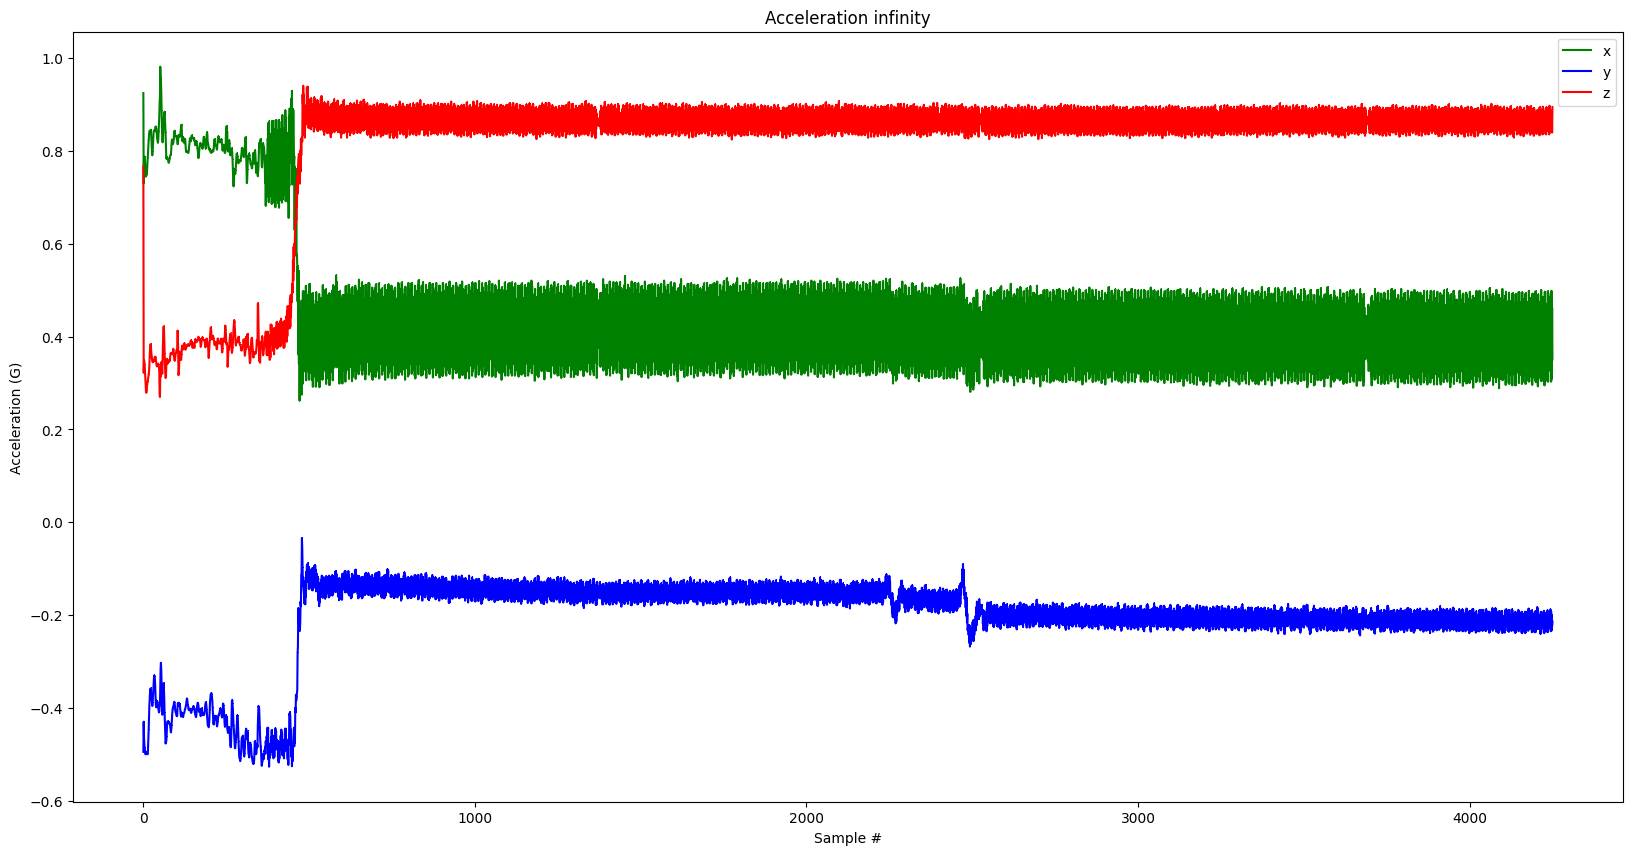

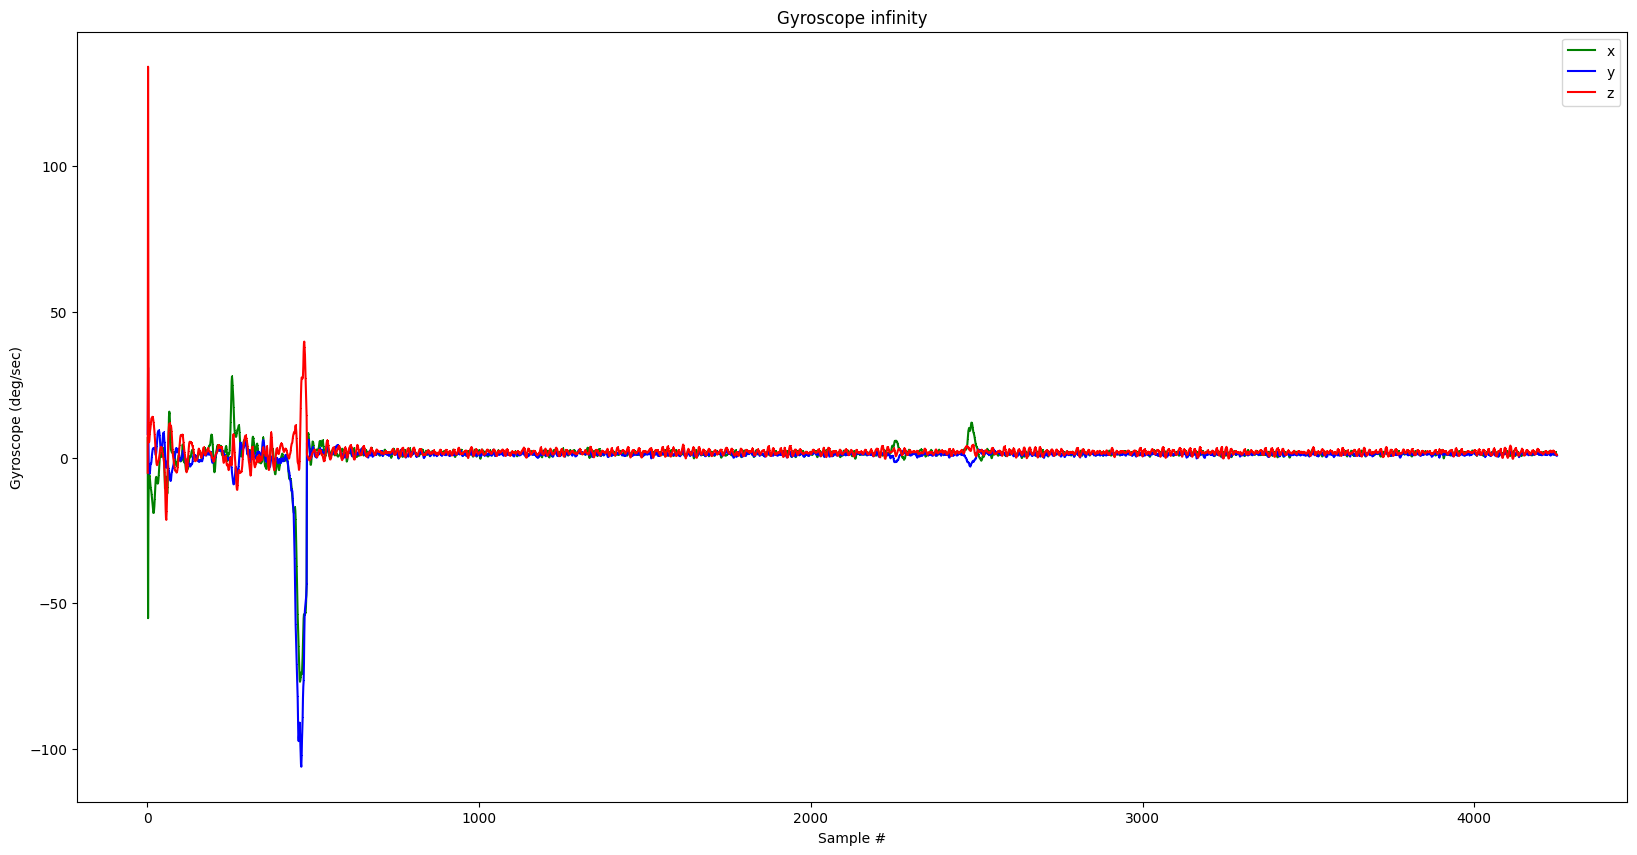

In [1]:
#  Lecture des données de vibration à partir d'un fichier CSV
#  Importation des bibliothèques nécessaires pour le traitement des données et l'entraînement du modèle
#  Lecture des données depuis un fichier CSV
#  Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "infinity.csv"

df = pd.read_csv(filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r', label='z', linestyle='solid', marker=',')
plt.title("Acceleration infinity")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope infinity")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()




## 2 . Prétraitement des données pour le Modèle de Machine Learning
Ce code est responsable de la lecture des données IMU (accéléromètre + gyroscope), de leur normalisation et de la transformation en un format exploitable pour un modèle TensorFlow.

In [4]:
#  Transformation des données brutes en un tenseur normalisé pour l'entrée du modèle
#  Calcul du nombre total d'enregistrements de vibrations dans le fichier CSV
#  Lecture des données de vibration à partir d'un fichier CSV
#  Définition du nombre d'échantillons par vibration
#  Définition d'une graine aléatoire pour garantir la reproductibilité des résultats
#  Importation des bibliothèques nécessaires pour le traitement des données et l'entraînement du modèle
#  Transformation des données d'entrée en un tenseur normalisé
#  Calcul du nombre total d'enregistrements de vibrations
#  Lecture des données depuis un fichier CSV
#  Définition du nombre d'échantillons par vibration
#  Définition d'une graine aléatoire pour la reproductibilité des résultats
#  Importation des bibliothèques nécessaires


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

VIBRATIONS = [
    "infinity",
    "vibration1"
]

SAMPLES_PER_GESTURE = 120

NUM_VIBRATIONS = len(VIBRATIONS)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_VIBRATIONS = np.eye(NUM_VIBRATIONS)

inputs = []
outputs = []

# read each csv file and push an input and output
for vibration_index in range(NUM_VIBRATIONS):
  vibration = VIBRATIONS[vibration_index]
  print(f"Processing index {vibration_index} for vibration '{vibration}'.")

  output = ONE_HOT_ENCODED_VIBRATIONS[vibration_index]

  df = pd.read_csv(vibration + ".csv")

  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)

  # calculate the number of vibration recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {vibration} vibration.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)



print("Data set parsing and preparation complete.")

TensorFlow version = 2.19.0

Processing index 0 for vibration 'infinity'.
	There are 35 recordings of the infinity vibration.
Processing index 1 for vibration 'vibration1'.
	There are 35 recordings of the vibration1 vibration.
Data set parsing and preparation complete.


## 3 .Randomisation et Séparation des Données
Ce bloc de code permet de mélanger aléatoirement les données et de les diviser en ensembles d’entraînement, de test et de validation.

In [5]:
#  Restructuration des entrées pour s'assurer qu'elles correspondent au format attendu par le modèle de deep learning
#  Séparation des données en trois ensembles : entraînement (train), test et validation
#  Mélange aléatoire des données pour éviter tout biais lors de l'entraînement
#  Reshape des entrées pour correspondre à la structure attendue par le modèle
#  Séparation des données en ensembles d'entraînement, de test et de validation
#  Mélange aléatoire des données pour éviter les biais
# Mélange des données pour éviter tout biais d'entraînement
num_inputs = len(inputs)  # Nombre total d'échantillons
randomize = np.arange(num_inputs)  # Création d'une liste d'indices [0, 1, 2, ..., num_inputs]
np.random.shuffle(randomize)  # Mélange aléatoire des indices

# Réorganisation des données en fonction du mélange
inputs = inputs[randomize]
outputs = outputs[randomize]

#  Séparation des données en trois ensembles : entraînement, test et validation
TRAIN_SPLIT = int(0.6 * num_inputs)  # 60% des données pour l'entraînement
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)  # 20% pour le test, 20% pour la validation

# Utilisation de np.split() pour diviser les ensembles
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

#  Suppression de toute nécessité de ExpandDims (n'est pas supporté par notre carte)
#  Correction : Reshape les entrées pour éviter ExpandDims
inputs_train = inputs_train.reshape(-1, 120, 6)
inputs_test = inputs_test.reshape(-1, 120, 6)
inputs_validate = inputs_validate.reshape(-1, 120, 6)

# Vérification après reshape
print(f" Shape après reshape : {inputs_train.shape}")  # Doit être (None, 120, 6)


print(f" Forme finale des données : {inputs_train.shape}, {outputs_train.shape}")
print("Mélange et séparation des données terminés.")


 Shape après reshape : (42, 120, 6)
 Forme finale des données : (42, 120, 6), (42, 2)
Mélange et séparation des données terminés.


 ## 4 .Entraînement d'un Modèle de Réseau de Neurones (MLP) avec TensorFlow
Ce code suivant définit, compile et entraîne un modèle de réseau de neurones utilisant Keras (dans TensorFlow). Ce modèle va apprendre à classer les vibrations en fonction des entrées d’un capteur IMU.


In [5]:
!pip install --upgrade tensorflow tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [ ]:
!pip install tensorflow-model-optimization

In [11]:
#  Importation des bibliothèques nécessaires pour le traitement des données et l'entraînement du modèle
#  Importation des bibliothèques nécessaires
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout

# Définition du modèle optimisé
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120, 6)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),

    tf.keras.layers.Dense(16, activation="relu"),

    tf.keras.layers.Dense(NUM_VIBRATIONS, activation="softmax")
])


# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle
model.summary()

# Entraînement
history = model.fit(
    inputs_train,
    outputs_train,
    epochs=300,
    batch_size=16,
    validation_data=(inputs_validate, outputs_validate),
    verbose=1
)

# Entraînement du modèle
#history = model.fit(inputs_train, outputs_train, epochs=1000, batch_size=32, validation_data=(inputs_validate, outputs_validate))

# Sauvegarde du modèle
model.save("vibration_model_cnn.h5")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 720)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │          23,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,634 (92.32 KB)

 Trainable params: 23,634 (92.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5119 - loss: 0.7181 - val_accuracy: 0.4286 - val_loss: 0.7102
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4881 - loss: 0.6975 - val_accuracy: 0.5714 - val_loss: 0.6791
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5119 - loss: 0.6889 - val_accuracy: 0.4286 - val_loss: 0.7103
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5119 - loss: 0.6925 - val_accuracy: 0.4286 - val_loss: 0.7265
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5119 - loss: 0.6957 - val_accuracy: 0.4286 - val_loss: 0.6926
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5595 - loss: 0.6836 - val_accuracy: 1.0000 - val_loss: 0.6792
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8065 - loss: 0.6782 - val_accuracy: 0.4286 - val_loss: 0.6865
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5119 - loss: 0.6774 - val_accuracy: 0.4286 - val_loss

## 5 . Test du modèle

## Visualisation de la Perte d'Entraînement
Ce code suivant trace les courbes de perte (loss) pour l'entraînement et la validation afin d’évaluer les performances du modèle.

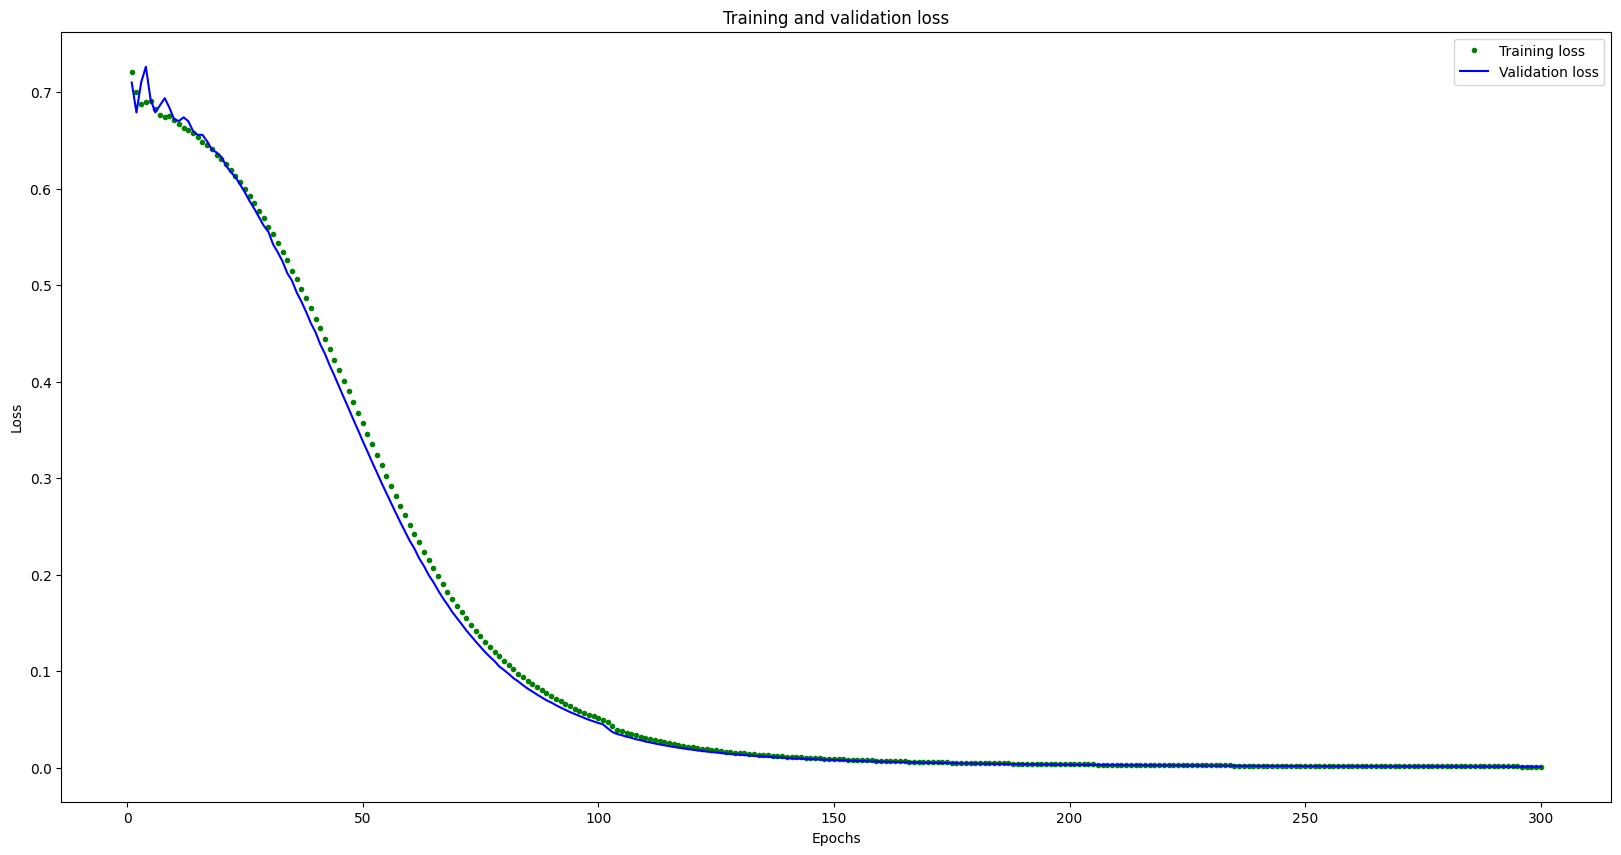

[20.0, 10.0]


In [12]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

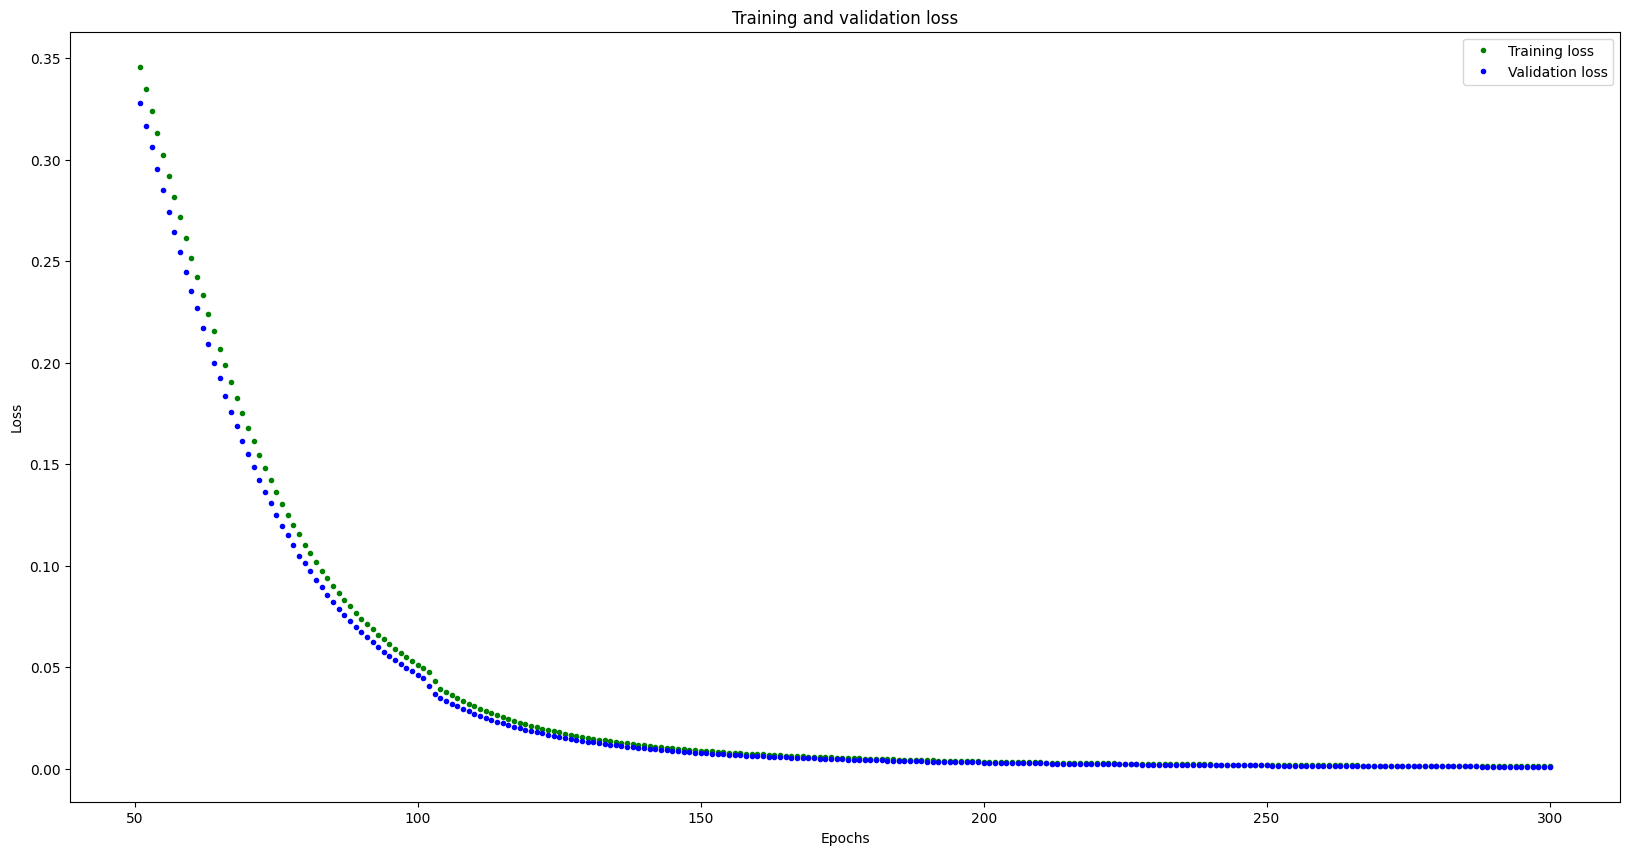

In [14]:
# graph the loss again skipping a bit of the start
SKIP = 50
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. Visualisation de la Précision (accuracy)
Ce code trace l'évolution de la précision (accuracy) du modèle pendant l'entraînement.

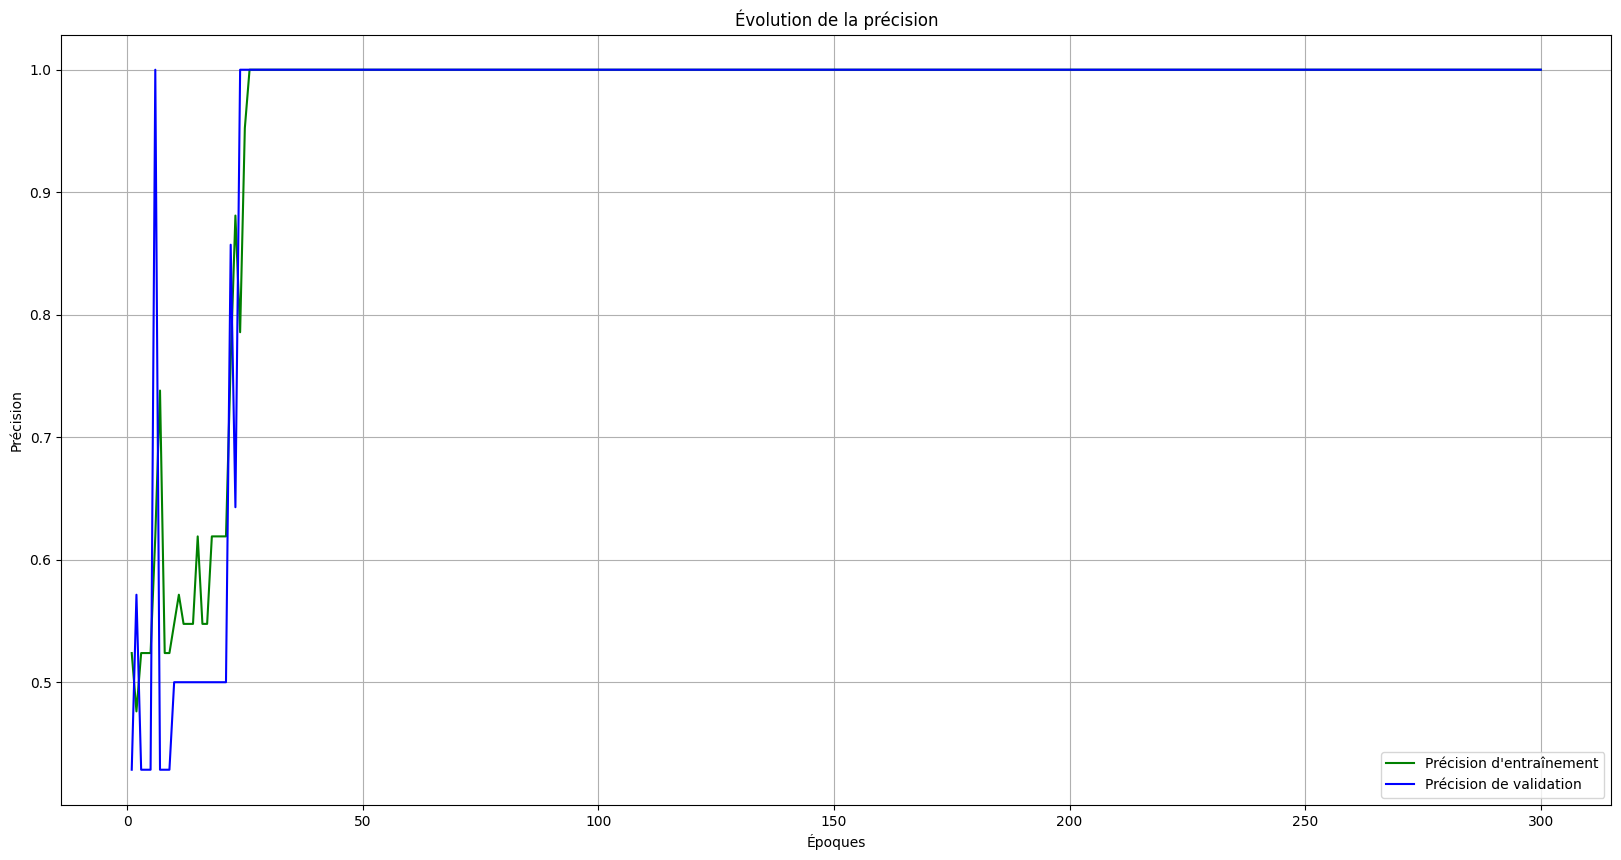

In [15]:
#  Importation des bibliothèques nécessaires pour le traitement des données et l'entraînement du modèle
#  Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt

# Récupération des valeurs d'accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Tracer l'accuracy d'entraînement et de validation
plt.plot(epochs, accuracy, 'g-', label='Précision d\'entraînement')
plt.plot(epochs, val_accuracy, 'b-', label='Précision de validation')

# Personnalisation du graphique
plt.title('Évolution de la précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

# Affichage
plt.show()

## 7. Prédiction et Comparaison avec les Valeurs Réelles
Ce code utilise le modèle entraîné pour faire des prédictions sur les données de test (inputs_test)
et compare ces prédictions aux valeurs attendues (outputs_test).

In [16]:
# Utiliser le modèle pour prédire les entrées de test
predictions = model.predict(inputs_test)
# Afficher les prédictions et les valeurs réelles
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
predictions =
 [[0.999 0.001]
 [1.    0.   ]
 [0.001 0.999]
 [0.999 0.001]
 [0.001 0.999]
 [0.999 0.001]
 [0.001 0.999]
 [0.001 0.999]
 [0.999 0.001]
 [0.002 0.998]
 [0.001 0.999]
 [1.    0.   ]
 [0.001 0.999]
 [0.999 0.001]]
actual =
 [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


## 8. Conversion du Modèle TensorFlow en TensorFlow Lite
Le code suivant convertit un modèle TensorFlow (.h5) en un modèle TensorFlow Lite (.tflite) pour une utilisation sur des microcontrôleurs ou des appareils embarqués.

In [17]:
#  Importation des bibliothèques nécessaires pour le traitement des données et l'entraînement du modèle
#  Importation des bibliothèques nécessaires
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]  # Opérations standard
tflite_model = converter.convert()

# Sauvegarde du modèle TFLite
with open("vibration_model.tflite", "wb") as f:
    f.write(tflite_model)


import os
basic_model_size = os.path.getsize("vibration_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmpbbuuizvq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 6), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134178711330384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134178583075280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134178583073744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134178583073168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134178583075088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134178583072400: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 96880 bytes


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import the generated model.h file as a tab into your Arduino sketch.

In [18]:
#  Importation des bibliothèques nécessaires pour le traitement des données et l'entraînement du modèle
#  Importation des bibliothèques nécessaires
!echo "const unsigned char model[] __attribute__((aligned(4))) = {"  > /content/model.h
!cat vibration_model.tflite | xxd -i                                  >> /content/model.h
!echo "};"                                                          >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 597,490 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
